# Functions

In [1]:
# Import statements

import h5py
import os
import numpy as np # type: ignore
import pandas as pd # type: ignore
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import cv2

from scipy.signal import savgol_filter


In [2]:

# functions

# filename = '/Users/ellasay/Google Drive/My Drive/behavior/1.SLEAP/h5/Archive/day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_restricted_wheel.h5'
def import_single_slp(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]

    print("===filename===")
    print(filename)
    print()

    print("===HDF5 datasets===")
    print(dset_names)
    print()

    print("===locations data shape===")
    print(locations.shape)
    print()

    print("===nodes===")
    for i, name in enumerate(node_names):
        print(f"{i}: {name}")
    print()

# Modified to apply to whole directory of h5 files

def import_h5_dir(directory):
    # Get a list of all .h5 files in the directory
    h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]

    # Initialize an empty list to store data for the DataFrame
    data = []

    for h5_file in h5_files:
        filename = os.path.join(directory, h5_file)
        
        # Open and process the .h5 file
        with h5py.File(filename, "r") as f:
            # dset_names = list(f.keys())
            locations = f["tracks"][:].T
            node_names = [n.decode() for n in f["node_names"][:]]
            
            # Append the data to the list
            condition = extract_condition(h5_file)
            filename = extract_filename(h5_file)
            data.append({
                'file_name': h5_file,
                'name': filename,
                'location shape': locations.shape,
                'locations': locations,
                'condition': condition

            })
    
    # Create a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def extract_condition(filename):
    start = filename.find("_") + 1
    end = filename.find("_0", start)
    if start > 1 and end > -1:
        return filename[start:end]
    return None

def extract_filename(filename):
    start = 0
    end = filename.find(".h5", start)
    return filename[start:end]
  


# Fill in missing values (NaN vavlues due to tracking errors)
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

NOSE_INDEX = 2
LEFTEAR_INDEX = 4
RIGHTEAR_INDEX = 0
TORSO_INDEX = 5
TAILBASE = 1
HEAD = 3

def store_nodes(row):
    nodes = {
        'nose':NOSE_INDEX,
        'leftear': LEFTEAR_INDEX,
        'rightear':RIGHTEAR_INDEX,
        'torso': TORSO_INDEX,
        'head': HEAD,
        # 'right_hindpaw':RIGHT_HINDPAW,
        'tailbase':TAILBASE
    }
    location_dict = {}
    locations = row['locations']

    for node, index in nodes.items():

        x_coords = locations[:,index,0,0].astype(float)
        y_coords = locations[:,index,1,0].astype(float)
        location_dict[f'{node}_x'] = x_coords
        location_dict[f'{node}_y'] = y_coords
        # node_loc = locations[:,index,:,:].reshape(-1)
        # location_dict[node] = node_loc

    return pd.Series(location_dict)


# Import dir of .slp files

In [3]:
directory_path = 'Z://giocomo/esay/cd_project/behavior/videos/all_videos/h5/day1/day1_restrictwheel_0914.1.mp4.000_day1_restrictwheel_0914.1.analysis.h5'  # Replace with your directory path
df = import_single_slp(directory_path)
print(df)

===filename===
Z://giocomo/esay/cd_project/behavior/videos/all_videos/h5/day1/day1_restrictwheel_0914.1.mp4.000_day1_restrictwheel_0914.1.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(18412, 6, 2, 1)

===nodes===
0: rightear
1: tailbase
2: nose
3: head
4: leftear
5: torso

None


In [4]:
directory_path = 'Z://giocomo/esay/cd_project/behavior/videos/all_videos/h5/day3'  # Replace with your directory path
video_dir = 'Z://giocomo/esay/cd_project/behavior/videos/day1'
# directory_path = '/Users/ellasay/Documents/can_project/all_h5'
df = import_h5_dir(directory_path)


In [ ]:
# organize into table based on condition

# conditions: fixed wheel vs not fixed wheel, novel vs familiar, restricted vs unrestricted


# Fill in NaN values

In [7]:
df['locations'] = df['locations'].apply(fill_missing) # fill_missing is NOT a vectorized function (cannot apply to whole column)
df = df.join(df.apply(store_nodes,axis=1))



In [8]:
df

,file_name,name,location shape,locations,condition,nose_x,nose_y,leftear_x,leftear_y,rightear_x,rightear_y,torso_x,torso_y,head_x,head_y,tailbase_x,tailbase_y
0,day3_unrestrictedfam_0914.1.mp4.000_day3_unres...,day3_unrestrictedfam_0914.1.mp4.000_day3_unres...,"(37081, 6, 2, 1)","[[[[222.1362915], [67.71788025]], [[325.764312...",unrestrictedfam,"[375.9977111816406, 375.9977111816406, 375.997...","[100.07432556152344, 100.07432556152344, 100.0...","[528.3648071289062, 528.3648071289062, 528.364...","[200.03829956054688, 200.03829956054688, 200.0...","[222.13629150390625, 222.13629150390625, 222.1...","[67.71788024902344, 67.71788024902344, 67.7178...","[353.94940185546875, 353.94940185546875, 353.9...","[349.888671875, 349.888671875, 349.888671875, ...","[385.8057556152344, 385.8057556152344, 385.805...","[148.0216522216797, 148.0216522216797, 148.021...","[325.7643127441406, 325.7643127441406, 325.764...","[319.96795654296875, 319.96795654296875, 319.9..."
1,day3_unrestrictedfam_0914.4.mp4.000_day3_unres...,day3_unrestrictedfam_0914.4.mp4.000_day3_unres...,"(36590, 6, 2, 1)","[[[[171.85108948], [197.62030029]], [[143.9725...",unrestrictedfam,"[390.16546630859375, 390.16546630859375, 390.1...","[102.10411071777344, 102.10411071777344, 102.1...","[576.451416015625, 576.451416015625, 576.45141...","[173.8617401123047, 173.8617401123047, 173.861...","[171.85108947753906, 171.85108947753906, 171.8...","[197.62030029296875, 197.62030029296875, 197.6...","[549.8300170898438, 549.8300170898438, 549.830...","[196.1374053955078, 196.1374053955078, 196.137...","[542.204833984375, 542.204833984375, 542.20483...","[226.35055541992188, 226.35055541992188, 226.3...","[143.9725341796875, 143.9725341796875, 143.972...","[372.2823486328125, 372.2823486328125, 372.282..."
2,day3_unrestrictedfam_0921.2.mp4.000_day3_unres...,day3_unrestrictedfam_0921.2.mp4.000_day3_unres...,"(37044, 6, 2, 1)","[[[[399.66320801], [107.55280304]], [[255.9481...",unrestrictedfam,"[386.0464172363281, 386.0464172363281, 386.046...","[103.90126037597656, 103.90126037597656, 103.9...","[17.90300750732422, 17.90300750732422, 17.9030...","[275.7588195800781, 275.7588195800781, 275.758...","[399.6632080078125, 399.6632080078125, 399.663...","[107.55280303955078, 107.55280303955078, 107.5...","[77.86663818359375, 77.86663818359375, 77.8666...","[179.946044921875, 179.946044921875, 179.94604...","[25.93558120727539, 25.93558120727539, 25.9355...","[255.88941955566406, 255.88941955566406, 255.8...","[255.9481964111328, 255.9481964111328, 255.948...","[38.0078125, 38.0078125, 38.0078125, 38.007812..."
3,day3_unrestrictednov_0914.1.mp4.000_day3_unres...,day3_unrestrictednov_0914.1.mp4.000_day3_unres...,"(37580, 6, 2, 1)","[[[[19.9130764], [162.08837891]], [[269.876556...",unrestrictednov,"[58.03936004638672, 58.03936004638672, 58.0393...","[327.9530944824219, 327.9530944824219, 327.953...","[476.20965576171875, 476.20965576171875, 476.2...","[130.1671142578125, 130.1671142578125, 130.167...","[19.913076400756836, 19.913076400756836, 19.91...","[162.08837890625, 162.08837890625, 162.0883789...","[443.9916076660156, 443.9916076660156, 443.991...","[220.2184600830078, 220.2184600830078, 220.218...","[28.12807273864746, 28.12807273864746, 28.1280...","[138.14369201660156, 138.14369201660156, 138.1...","[269.8765563964844, 269.8765563964844, 269.876...","[370.2518005371094, 370.2518005371094, 370.251..."
4,day3_unrestrictednov_0914.4.mp4.000_day3_unres...,day3_unrestrictednov_0914.4.mp4.000_day3_unres...,"(38586, 6, 2, 1)","[[[[676.10003662], [13.98895073]], [[72.253440...",unrestrictednov,"[392.2410888671875, 392.2410888671875, 392.241...","[103.92833709716797, 103.92833709716797, 103.9...","[581.9226684570312, 581.9226684570312, 581.922...","[250.03672790527344, 250.03672790527344, 250.0...","[676.1000366210938, 676.1000366210938, 676.100...","[13.988950729370117, 13.988950729370117, 13.98...","[450.15155029296875, 450.15155029296875, 450.1...","[226.09014892578125, 226.0901489257

In [ ]:
# add head as a node (average between ears) because ears are the most consistent in video

df['head_x'] = (df['leftear_x'] + df['rightear_x']) / 2
df['head_y'] = (df['leftear_y'] + df['rightear_y']) / 2

## algorithm for calculating interaction

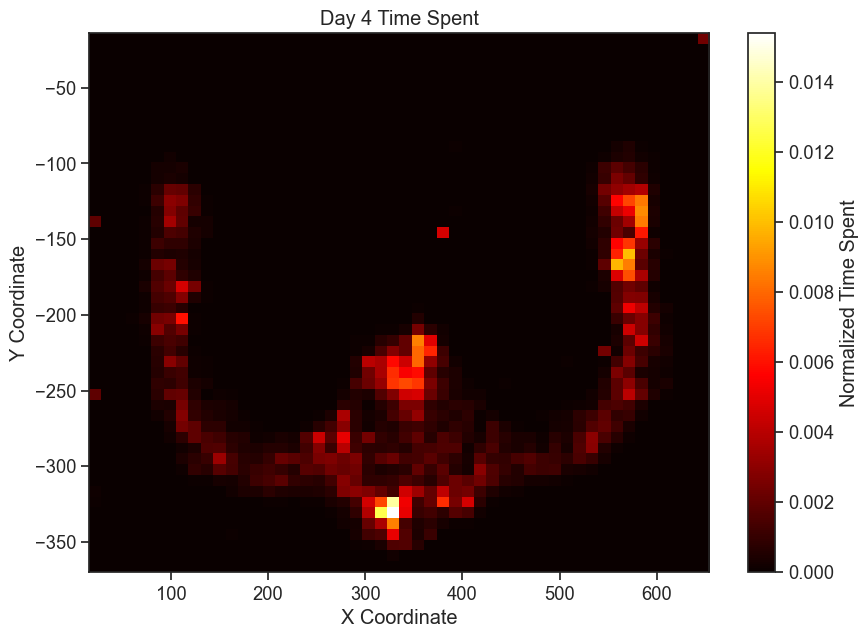

In [60]:
# create heat map for time spent across frames 

all_x = np.concatenate((df['head_x']).to_numpy())
all_y = np.concatenate(-(df['head_y']).to_numpy())
# Create a 2D histogram
heatmap, xedges, yedges = np.histogram2d(all_x, all_y, bins=50)  # Adjust `bins` as needed
# Normalize the histogram to represent relative time spent
heatmap = heatmap / heatmap.sum()
# Plot the heatmap
plt.figure(figsize=(10, 7))
plt.imshow(
    heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='hot',
    aspect='auto'
)
plt.colorbar(label='Normalized Time Spent')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Day 4 Time Spent')
plt.show()

In [ ]:
# create 3 zones (ends, corners, interaction zone)

In [ ]:
# calculate nose orientation relative to head

delta_list = []
for idx, row in df.iterrows():
    nose2head= np.sqrt((row['head_x']-row['nose_x'])**2 +(row['head_y']-row['nose_y'])**2)
    ear2head = np.sqrt((row['rightear_x']-row['nose_x'])**2 +(row['rightear_y']-row['nose_y'])**2)
    delta = np.degrees(np.arctan(nose2head/ear2head))
    delta_list.append(delta)
df['delta'] = delta_list

In [ ]:
# while in interaction zone, see what the orientation angles are
# Plot each row's filtered delta values
plt.figure(figsize=(10, 6))
for idx, row in df.iterrows():
    # Extract the filtered frames and corresponding delta values
    filtered_indices = row['filtered_frames']
    filtered_angles = [row['delta'][i] for i in filtered_indices]
    # Plot filtered angles
    plt.plot(filtered_indices, filtered_angles, marker='o', linestyle='-', label=f'Row {idx}')
# Add title, labels, and legend
plt.title('Filtered Orientation Angles', fontsize=16)
plt.xlabel('Frame Number', fontsize=12)
plt.ylabel('Orientation Angle (Delta)', fontsize=12)
plt.legend(title='Row Index')
plt.grid(True)
# Show the plot
plt.show()


(1027, 624, 688, 362)


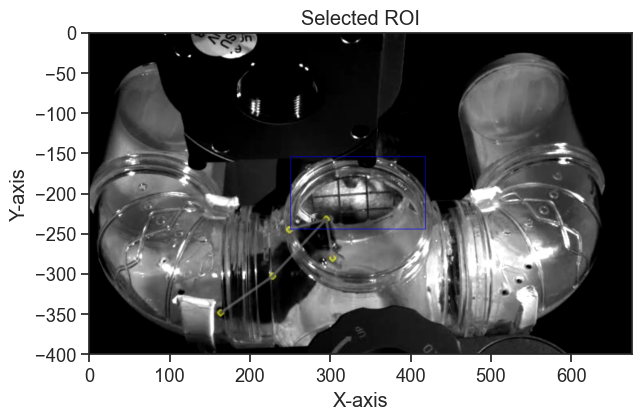

In [83]:
# draw roi of other mouse nose

import cv2
import matplotlib.pyplot as plt

image = cv2.imread("day1_restrictwheel_0914.1.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

r = cv2.selectROI("Select the area", image, showCrosshair=True)
print(r)
image_with_rectangle = image.copy()
cv2.rectangle(image_with_rectangle, (int(r[0]), int(r[1])),
              (int(r[0] + r[2]), int(r[1] + r[3])),
              color=(255, 0, 0), thickness=2)  # Blue rectangle

image_with_rectangle_rgb = cv2.cvtColor(image_with_rectangle, cv2.COLOR_BGR2RGB)
# Display the image with axes and the blue crop area
# plt.figure(figsize=(8, 6))

fig, ax = plt.subplots(figsize=(7, 7))

# fig,ax = plt.figure(figsize=(7, 7))

ax.set_xlim(0, 675)
ax.set_ylim(-400, 0)

# plt.imshow(image_with_rectangle_rgb)
ax.imshow(image_with_rectangle_rgb,extent=[0, 675, -400, 0])


plt.title("Selected ROI")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()
# Close ROI selection window
cv2.destroyAllWindows()




## interaction zone method

In [56]:
def def_interaction_zone(filtered_frames,conditions):
    for i, row in df.iterrows():
        # nose_x = np.array(row['nose_x']).astype(float)
        # nose_y = np.array(row['nose_y']).astype(float)
    
        head_x = np.array(row['head_x']).astype(float)
        head_y = np.array(row['head_y']).astype(float)
        
        # interaction zone x = [300,400] y=[200,300]
        # int_zone = (nose_x >= 300) & (nose_x <= 400) & (nose_y >= 200) & (nose_y <= 300)
        int_zone = (head_x >= 300) & (head_x <= 400) & (head_y >= 200) & (head_y <= 250)
    
        frame_indices = np.where(int_zone)[0]  
    
        filtered_frames.append(frame_indices)
        conditions.append(row['condition'])  # Store condition for color
        conditions = edit_names(conditions)

def edit_names(conditions):
    replacements = {
        "restrictedwheel":"restrictwheel",
        "unrestricted_fam":"unrestrictedfam"
    }
    for old, new in replacements.items():
        conditions = [condition.replace(old,new) for condition in conditions]
    return conditions
    

In [ ]:
# quantify amount of time spent on the sides vs the middle

# Initialize an empty list to store frame indices for each trial
filtered_frames = []
conditions = []
def_interaction_zone(filtered_frames,conditions)

df['filtered_frames'] = filtered_frames
# plot raster
fig, ax = plt.subplots(figsize=(10, 6))

for i, frames in enumerate(filtered_frames):
    ax.plot(frames, np.ones_like(frames) * i, '|', color='black', markersize=10)  # Raster points for each trial

# Labeling the plot
ax.set_title('Time spent in interaction zone')
ax.set_xlabel('Frame')
ax.set_ylabel('Trial')
ax.set_yticks(range(len(filtered_frames)))
ax.set_yticklabels(df['name'])

ax.set_ylim(-1, len(filtered_frames))

plt.show()





In [ ]:
# plot raster with colors + days 
import matplotlib.patches as mpatches

condition_colors = {
    # "restrictedwheel": "grey",
    "restrictwheel": "blue",
    "unrestrictednov": "limegreen",
    "unrestrictednovdiffsex": "cyan",
    "unrestrictedfam": "magenta"
    # "unrestricted_fam": "orange"
}

# Initialize an empty list to store frame indices for each trial and colors for each condition
filtered_frames = []
conditions = []

# Extract day number and add as a new column for sorting
df['day'] = df['name'].str.extract(r'day(\d)').astype(int)
# df = df.sort_values(by='day').reset_index(drop=True)
df = df.sort_values(by=['day', 'condition']).reset_index(drop=True)


# rewrite this so it doesn't need to recaclulate interaction zone and can just use the filtered_frames 
def_interaction_zone(filtered_frames,conditions)


# Plot raster
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each trial's data with appropriate color based on condition
for i, (frames, condition) in enumerate(zip(filtered_frames, conditions)):
    ax.plot(frames, np.ones_like(frames) * i, '|', color=condition_colors[condition], markersize=12)

# Labeling the plot
ax.set_title('Time Spent in Interaction Zone')
ax.set_xlabel('Frame')
ax.set_ylabel('Trial')
# ax.set_yticks(range(len(filtered_frames)))
# ax.set_yticklabels(df['name'])



# Draw dotted lines between days
unique_days = df['day'].unique()
day_labels = []
day_positions = []

for day in unique_days:
    day_indices = df[df['day'] == day].index
    center_position = (day_indices[0] + day_indices[-1]) / 2
    day_labels.append(f'day{day}') 
    day_positions.append(center_position)

ax.set_yticks(day_positions)
ax.set_yticklabels(day_labels)

# Draw dotted lines between days
for day in unique_days[1:]:  # Skip the first day to avoid a line at the top
    idx = df[df['day'] == day].index[0] - 0.5
    ax.axhline(idx, linestyle='--', color='gray')

ax.set_ylim(-1, len(filtered_frames))


legend_patches = [mpatches.Patch(color=color, label=condition) for condition, color in condition_colors.items()]
ax.legend(handles=legend_patches, title="Condition", loc='upper right')


plt.show()





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define colors for each condition
condition_colors = {
    "restrictwheel": "blue",
    "unrestrictednov": "lawngreen",
    "unrestrictednovdiffgen": "dodgerblue",
    "unrestrictedfam": "deeppink"
}

# Extract day number and identifier from the name column
df['day'] = df['name'].str.extract(r'day(\d)').astype(int)
df['id'] = df['name'].str.extract(r'(0914\.1|0914\.4|0921\.2)')[0]

# Filter the DataFrame to only include rows with the specific IDs we're interested in
unique_ids = df['id'].dropna().unique()

# Loop through each unique ID to create a separate raster plot
for identifier in unique_ids:
    # Filter the DataFrame for the current identifier
    df_id = df[df['id'] == identifier].sort_values(by=['day', 'condition']).reset_index(drop=True)
    
    # Initialize lists to store frame indices and conditions
    filtered_frames = []
    conditions = []
    
    
    # Loop through each row to calculate frame indices within the interaction zone
    for i, row in df_id.iterrows():
        head_x = np.array(row['head_x']).astype(float)
        head_y = np.array(row['head_y']).astype(float)
        
        # Define interaction zone
        int_zone = (head_x >= 300) & (head_x <= 400) & (head_y >= 200) & (head_y <= 250)
        frame_indices = np.where(int_zone)[0]  

        filtered_frames.append(frame_indices)
        conditions.append(row['condition'])  # Store condition for color
        
    # Create a raster plot for the current identifier
    conditions = edit_names(conditions)
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot each trial's data with the appropriate color based on condition
    for i, (frames, condition) in enumerate(zip(filtered_frames, conditions)):
        ax.plot(frames, np.ones_like(frames) * i, '|', color=condition_colors[condition], markersize=15)

    # Labeling the plot
    ax.set_title(f'Time Spent in Interaction Zone ({identifier})')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Day')

    # Adjust y-axis labels to display each day only once
    unique_days = df_id['day'].unique()
    day_labels = []
    day_positions = []

    for day in unique_days:
        day_indices = df_id[df_id['day'] == day].index
        center_position = (day_indices[0] + day_indices[-1]) / 2
        day_labels.append(f'day{day}')
        day_positions.append(center_position)

    ax.set_yticks(day_positions)
    ax.set_yticklabels(day_labels)

    # Draw dotted lines between days
    for day in unique_days[1:]:  # Skip the first day to avoid a line at the top
        idx = df_id[df_id['day'] == day].index[0] - 0.5
        ax.axhline(idx, linestyle='--', color='gray')

    ax.set_ylim(-1, len(filtered_frames))

    # Create legend
    legend_patches = [mpatches.Patch(color=color, label=condition) for condition, color in condition_colors.items()]
    ax.legend(handles=legend_patches, title="Condition",loc='upper right')

    ax.legend(handles=legend_patches, title="Condition", loc='upper left', bbox_to_anchor=(1.05, 1))

    # Adjust layout to fit the legend
    plt.subplots_adjust(right=0.8)

    # Show the plot for this identifier
    plt.show()
    # Show the plot for this identifier
    plt.show()


In [ ]:
filtered_frames

In [ ]:
percent_interact = []
for i in range(0, len(df)):
    int_frames = len(df["filtered_frames"][i])
    total_frames = df["location shape"].iloc[i][0]
    temp_percent = (int_frames/total_frames)*100
    percent_interact.append(temp_percent)

df['percent_interact'] = percent_interact

# df['name'],df['percent_interact']


# Analysis

In [61]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

In [10]:
df

,file_name,name,location shape,locations,condition,nose_x,nose_y,leftear_x,leftear_y,rightear_x,rightear_y,torso_x,torso_y,head_x,head_y,tailbase_x,tailbase_y
0,day1_restrictwheel_0914.1.mp4.000_day1_restric...,day1_restrictwheel_0914.1.mp4.000_day1_restric...,"(18412, 6, 2, 1)","[[[[287.85293579], [314.09051514]], [[160.2087...",restrictwheel,"[313.7416687011719, 313.7879943847656, 313.785...","[300.1186218261719, 300.13543701171875, 300.14...","[278.0289306640625, 278.0469970703125, 278.061...","[266.1455993652344, 266.15692138671875, 266.16...","[287.8529357910156, 287.8540954589844, 287.852...","[314.09051513671875, 314.10113525390625, 314.0...","[225.8215789794922, 225.85040283203125, 225.86...","[304.05169677734375, 304.0104064941406, 304.00...","[279.86541748046875, 279.8787841796875, 279.88...","[296.1728515625, 296.1820068359375, 296.181823...","[160.20870971679688, 161.73948669433594, 161.7...","[343.73968505859375, 343.80718994140625, 343.8..."
1,day1_restrictwheel_0914.4.mp4.000_day1_restric...,day1_restrictwheel_0914.4.mp4.000_day1_restric...,"(19079, 6, 2, 1)","[[[[358.02407837], [287.86489868]], [[294.0749...",restrictwheel,"[331.9429626464844, 331.93548583984375, 331.92...","[240.1422119140625, 240.14974975585938, 240.14...","[295.75640869140625, 295.7265319824219, 295.72...","[267.9024353027344, 267.868408203125, 267.8355...","[358.0240783691406, 358.0053405761719, 357.919...","[287.8648986816406, 287.7855224609375, 286.197...","[317.98089599609375, 317.9919738769531, 317.98...","[321.84967041015625, 321.84979248046875, 321.8...","[324.0859375, 324.09716796875, 324.14944458007...","[279.7752380371094, 279.74169921875, 278.25790...","[294.074951171875, 294.1087951660156, 294.1013...","[376.12371826171875, 376.0773620605469, 376.06..."
2,day1_restrictwheel_0921.2.mp4.000_day1_restric...,day1_restrictwheel_0921.2.mp4.000_day1_restric...,"(21032, 6, 2, 1)","[[[[332.22647095], [227.90646362]], [[328.2755...",restrictwheel,"[294.002197265625, 294.01800537109375, 294.041...","[201.7292022705078, 201.75335693359375, 201.76...","[296.1584167480469, 294.24072265625, 294.21105...","[248.08595275878906, 248.12327575683594, 248.1...","[332.2264709472656, 331.9211730957031, 331.888...","[227.90646362304688, 229.81092834472656, 229.8...","[337.9361267089844, 336.00262451171875, 335.74...","[282.0679931640625, 284.0199279785156, 286.025...","[316.2410583496094, 314.2061767578125, 314.151...","[242.2312774658203, 243.80194091796875, 243.83...","[328.27557373046875, 326.3163757324219, 326.25...","[360.3076171875, 362.1067810058594, 362.150878..."
3,day1_unrestricted_fam_0914.1.mp4.000_day1_unre...,day1_unrestricted_fam_0914.1.mp4.000_day1_unre...,"(36158, 6, 2, 1)","[[[[250.29785156], [287.98422241]], [[372.1408...",unrestricted_fam,"[198.10821533203125, 198.04017639160156, 198.1...","[338.0320129394531, 340.0006408691406, 342.052...","[250.06546020507812, 249.7792510986328, 248.11...","[329.7460021972656, 331.9990539550781, 335.739...","[250.2978515625, 249.912841796875, 250.1054229...","[287.9842224121094, 288.3864440917969, 292.177...","[280.05670166015625, 280.04559326171875, 279.9...","[319.9189758300781, 321.7540588378906, 321.979...","[248.1342010498047, 248.0069122314453, 247.950...","[311.81787109375, 313.85821533203125, 316.0711...","[372.14080810546875, 372.14080810546875, 372.1...","[342.1783447265625, 342.1783447265625, 342.178..."
4,day1_unrestricted_fam_0914.4.mp4.000_day1_unre...,day1_unrestricted_fam_0914.4.mp4.000_day1_unre...,"(35830, 6, 2, 1)","[[[[157.79594421], [313.85769653]], [[69.79423...",unrestricted_fam,"[201.81088256835938, 201.8924102783203, 202.02...","[318.0133361816406, 317.9403381347656, 317.916...","[168.2391357421875, 169.92849731445312, 169.90...","[268.08349609375, 268.0702819824219, 268.06134...","[157.7959442138672, 158.14076232910156, 158.12...","[313.8576965332031, 314.00762939453125, 313.98...","[135.90689086914062, 136.09317016601562, 136.0...","[279.8193664550781, 280.0123291015625, 

Text(0.5, 1.0, 'Ear tracks')

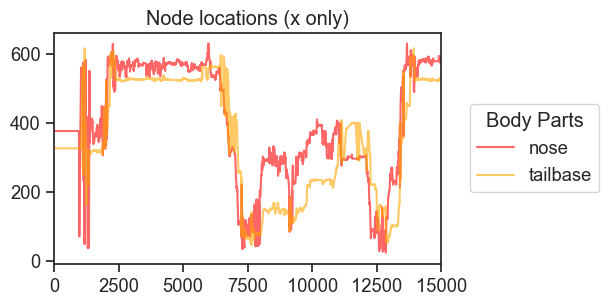

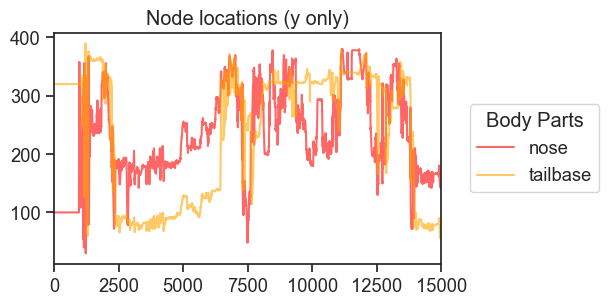

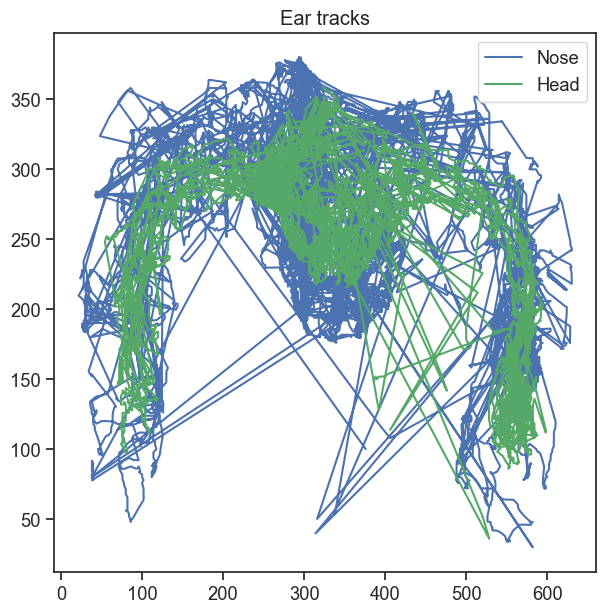

In [62]:
i = 0
plt.figure(figsize=(5,3))
plt.plot(df['nose_x'].iloc[i], 'red',label='nose',alpha=0.6)
# plt.plot(df['rightear_x'].iloc[i], 'purple',label='right_ear',alpha=0.6)
# plt.plot(df['leftear_x'].iloc[i], 'g',label='left_ear',alpha=0.6)
# plt.plot(df['head_x'].iloc[i], 'black',label='head',alpha=0.6)
# plt.plot(df['torso_x'].iloc[i], 'b',label='torso',alpha=0.5)
plt.plot(df['tailbase_x'].iloc[i], 'orange',label='tailbase',alpha=0.6)
plt.xlim(0, 15000)
# plt.yticks(np.arange(min(df['tailbase_x'].iloc[i]), max(df['tailbase_x'].iloc[i])+1, 40))
# plt.xticks(np.arange(0,15000,1000))
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="Body Parts")
plt.title('Node locations (x only)')

# Adjust layout to make space for the legend
# plt.subplots_adjust(right=0.8)

plt.figure(figsize=(5,3))
plt.plot(df['nose_y'].iloc[i], 'red',label='nose',alpha=0.6)
# plt.plot(df['rightear_x'].iloc[i], 'purple',label='right_ear',alpha=0.6)
# plt.plot(df['leftear_x'].iloc[i], 'g',label='left_ear',alpha=0.6)
# plt.plot(df['head_x'].iloc[i], 'black',label='head',alpha=0.6)
# plt.plot(df['torso_x'].iloc[i], 'b',label='torso',alpha=0.5)
plt.plot(df['tailbase_y'].iloc[i], 'orange',label='tailbase',alpha=0.6)
plt.xlim(0, 15000)
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="Body Parts")
plt.title('Node locations (y only)')


plt.figure(figsize=(7,7))
plt.plot(df['nose_x'][i],1*df['nose_y'][i], 'b',label='Nose')
# plt.plot(df['leftear_x'][i],-1*df['leftear_y'][i], 'b',label='Left ear')
# plt.plot(df['rightear_x'][i],-1*df['rightear_y'][i], 'r',label='Right ear')
plt.plot(df['head_x'][i],1*df['head_y'][i], 'g',label='Head')


plt.legend()

# plt.xlim(0,700)
# # plt.xticks([])

# plt.ylim(-500,0)
#plt.yticks([])
plt.title('Ear tracks')

# color 250-450 as "interaction phase"


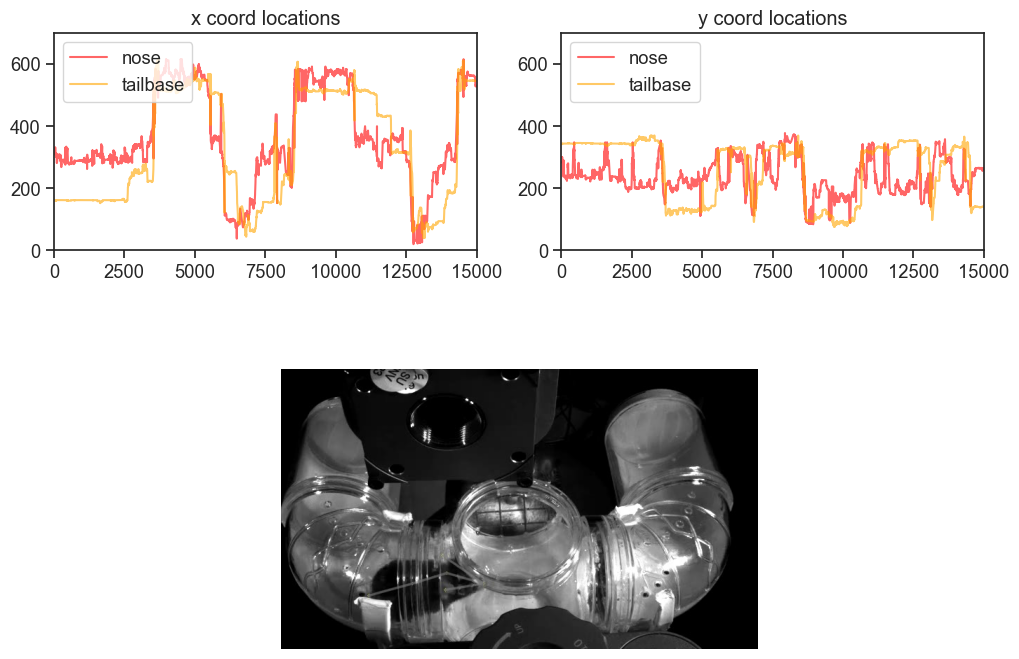

In [14]:
# plot video alongside live node trace
import matplotlib.gridspec as gridspec
from matplotlib.animation import FFMpegWriter

video_path = 'Z://giocomo/esay/cd_project/behavior/videos/all_videos/day1_restrictwheel_0914.1.mp4.predictions.slp.avi'
cap = cv2.VideoCapture(video_path)

x_range = range(1, len(df['nose_x'].iloc[i])+1)
nose_x = df['nose_x'].iloc[i]
nose_y = df['nose_y'].iloc[i]
tailbase_x = df['tailbase_x'].iloc[i]
tailbase_y = df['tailbase_y'].iloc[i]

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
fig, axes = plt.subplots(3, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 1, 0.5]}) 
ax1, ax2 = axes[0, 0], axes[0, 1] 
fig.delaxes(axes[1,0])
fig.delaxes(axes[1,1])
fig.delaxes(axes[2,0])
fig.delaxes(axes[2,1])
ax_video = fig.add_subplot(2,1,2)

line1, = ax1.plot([],[],'red',label='nose',alpha=0.6)
line2,= ax1.plot([],[],'orange',label='tailbase',alpha=0.6)
line3, = ax2.plot([],[],'red',label='nose',alpha=0.6)
line4, = ax2.plot([],[],'orange',label='tailbase',alpha=0.6)

ax1.set_xlim(0,15000)
ax1.set_ylim(0,700)
ax1.set_title("x coord locations")
ax1.legend(loc='upper left')

ax2.set_xlim(0,15000)
ax2.set_ylim(0,700)
ax2.set_title("y coord locations")
ax2.legend(loc='upper left')


def update(frame, x_range, nose_x, nose_y, tailbase_x, tailbase_y, cap):
    line1.set_data(x_range[:frame], nose_x[:frame])
    line2.set_data(x_range[:frame], tailbase_x[:frame])
    line3.set_data(x_range[:frame], nose_y[:frame])
    line4.set_data(x_range[:frame], tailbase_y[:frame])

    # display video
    ret, frame_img = cap.read()
    if ret:
        frame_img = cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB)
        # fig.figimage(frame_img, xo=0,yo=0,alpha=0.3)
        ax_video.clear()
        ax_video.imshow(frame_img)
        ax_video.axis('off')
    return line1, line2, line3, line4 
    
ani = animation.FuncAnimation(fig, update, frames=len(x_range), fargs=[x_range, nose_x, nose_y, tailbase_x, tailbase_y, cap],
                              interval=5, blit=True)
writer = FFMpegWriter(fps=60, metadata = dict(artist='Me'), bitrate=500)
ani.save('coords_w_vid.mp4',writer=writer)
cap.release()
plt.show()


In [63]:
# orientation angle 
delta_list = []
for idx, row in df.iterrows():
    # nose2head= np.sqrt((row['tailbase_x']-row['nose_x'])**2 +(row['tailbase_y']-row['nose_y'])**2)
    delta = np.degrees(np.arctan((row['tailbase_y']-row['nose_y'])/(row['tailbase_x']-row['nose_x'])))
    delta_list.append(delta)
df['delta_nose_tailbase'] = delta_list

# interaction zone (260,360)
# arms (40,200) and (400,600)
# corners - transient spaces (200,260) and (360,400)


In [64]:
df['delta_nose_tailbase']

0    [-77.1319328363206, -77.1319328363206, -77.131...
1    [-47.65946240523914, -47.65946240523914, -47.6...
2    [26.861757957926873, 26.861757957926873, 26.86...
3    [11.292056042932687, 11.292056042932687, 11.29...
4    [-6.77562097206313, -6.77562097206313, -6.7756...
5    [40.7777541805351, 40.7777541805351, 40.777754...
Name: delta_nose_tailbase, dtype: object

In [80]:
# while in interaction zone (currently manually defined) when is mouse oriented? 

def check_oriented(interaction_zone_x, environment_zone_1_x, environment_zone_2_x):
    int_zone = []
    env_zone = []
    conditions = []
    oriented = []  
    int_oriented = []
    for i, row in df.iterrows():
        # Get x and y coordinates for head and tail base
        head_x = np.array(row['head_x']).astype(float)
        head_y = np.array(row['head_y']).astype(float)
        tailbase_y = np.array(row['tailbase_y']).astype(float)

        # zones are only based on x value along "track"
        interaction = (head_x >= interaction_zone_x[0]) & (head_x <= interaction_zone_x[1]) 
        env_zone_1 = (head_x >= environment_zone_1_x[0]) & (head_x <= environment_zone_1_x[1])
        env_zone_2 = (head_x >= environment_zone_2_x[0]) & (head_x <= environment_zone_2_x[1])
        
        # Find frame indices for interaction zone / environment zone 
        int_idx = np.where(interaction)[0]
        int_zone.append(int_idx)

        env_idx = np.where(env_zone_1 | env_zone_2)[0]
        env_zone.append(env_idx)
        
        conditions.append(row['condition'])  # Store condition for color
        conditions = edit_names(conditions)

        
        # Check orientation within the interaction zone
        for frame in int_idx:  # Check if any frames fall into the interaction zone
            if head_y[frame] < tailbase_y[frame]:  # Head is above the tailbase
                oriented.append(frame)  
        int_oriented.append(oriented) # this is wrong right now!!!!!
        
    df['int_zone'] = int_zone 
    df['env_zone'] = env_zone
    df['oriented'] = int_oriented

In [81]:
int_zone = (260,360)
env_zone_a = (40,200)
env_zone_b = (360,600)

check_oriented(int_zone, env_zone_a, env_zone_b)



In [82]:
df['oriented']

0    [1189, 1190, 1191, 1192, 1193, 1194, 1219, 122...
1    [1189, 1190, 1191, 1192, 1193, 1194, 1219, 122...
2    [1189, 1190, 1191, 1192, 1193, 1194, 1219, 122...
3    [1189, 1190, 1191, 1192, 1193, 1194, 1219, 122...
4    [1189, 1190, 1191, 1192, 1193, 1194, 1219, 122...
5    [1189, 1190, 1191, 1192, 1193, 1194, 1219, 122...
Name: oriented, dtype: object

In [ ]:
df['delta_nose_tailbase'][2]

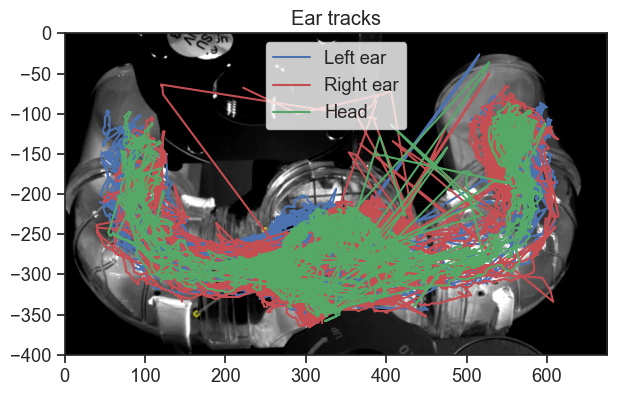

In [84]:
import matplotlib.pyplot as plt

# Load the image
img = plt.imread("day1_restrictwheel_0914.1.png")

# Set up the figure and axes with the specified size
fig, ax = plt.subplots(figsize=(7, 7))

# Display the image in the background
ax.imshow(img, extent=[0, 675, -400, 0])

# Plot the ear and head tracks
i = 0  # Example index; modify as needed for specific trials or data points
ax.plot(df['leftear_x'][i], -1 * df['leftear_y'][i], 'b', label='Left ear')
ax.plot(df['rightear_x'][i], -1 * df['rightear_y'][i], 'r', label='Right ear')
ax.plot(df['head_x'][i], -1 * df['head_y'][i], 'g', label='Head')

# Set limits to match the image size
ax.set_xlim(0, 675)
ax.set_ylim(-400, 0)

# Add legend and title
ax.legend()
ax.set_title('Ear tracks')

plt.show()


In [5]:

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [99]:
nose_loc

[array([375.99771118, 375.99771118, 375.99771118, ..., 361.14828491,
        366.60598755, 372.06369019], shape=(37081,)),
 array([100.07432556, 100.07432556, 100.07432556, ..., 205.1388092 ,
        209.61856842, 214.09832764], shape=(37081,))]

In [9]:
i=0 
nose_loc = []
nose_loc.append(df['nose_x'].iloc[i])
nose_loc.append(df['nose_y'].iloc[i])
nose_vel = smooth_diff(nose_loc[:,:,0])
# torso_vel = smooth_diff(torso_loc[:,:,0])


TypeError: list indices must be integers or slices, not tuple

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(nose_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*nose_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Nose')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(nose_vel[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

In [ ]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(nose_loc[:, 0, 0], -1*nose_loc[:, 1, 0], 'k')
ax1.plot(torso_loc[:, 0, 0], -1*torso_loc[:, 1, 0], 'r')
ax1.set_xlim(0,800)
ax1.set_xticks([])
ax1.set_ylim(-500,0)
ax1.set_yticks([])
ax1.set_title('Nose tracks')

kp = nose_vel  
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(nose_loc[:,0,0], -1*nose_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)

ax2.set_xlim(0,800)
ax2.set_xticks([])
ax2.set_ylim(-500,0)
ax2.set_yticks([])
ax2.set_title('Nose tracks colored by magnitude of animal speed')


# lp = torso_vel
# ax3 = fig.add_subplot(120)
# ax3.scatter(torso_loc[:,0,0], -1*torso_loc[:,1,0], c=lp, s=4, vmin=vmin, vmax=vmax)

# ax3.set_xlim(0,800)
# ax3.set_xticks([])
# ax3.set_ylim(-500,0)
# ax3.set_yticks([])
# ax3.set_title('Torso tracks colored by magnitude of animal speed')

In [ ]:
def instance_node_velocities(instance_idx):
    node_locations = locations[:, :, :, instance_idx]
    node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        node_velocities[:, n] = smooth_diff(node_locations[:, n, :])
    
    return node_velocities

In [ ]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Animal {instance_idx} node velocities')

In [ ]:
animal_ID = 0
node_velocities = instance_node_velocities(animal_ID)
plot_instance_node_velocities(animal_ID, node_velocities)